<a href="https://colab.research.google.com/github/MilerDiazZevallos/DataScientist/blob/master/Sala_Situacional_Arequipa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Funcion R

In [ ]:
#@title
# general imports
import numpy as np
import datetime as dt

from joblib import Parallel, delayed

# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.01

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

    #print(smoothed_cases.to_csv('smoothed_cases'))

    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)

    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())

    #print('End smoothed')
    return original, smoothed_cases
    

def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)

    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    

def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval
    

def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")

    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1)) 


def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)

    return result

# Cargar Datos

In [ ]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

In [ ]:
datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
print(datos_arequipa.shape)

,date,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades
48,2020-06-18,127320,7590,119647,83,187,3488,274,137,50,13,77,100,5,3,2
49,2020-06-19,131806,7954,123769,83,203,3680,276,158,46,19,84,109,5,3,2
50,2020-06-20,136389,8373,127953,63,211,3820,282,158,45,20,84,117,5,3,2
51,2020-06-21,141038,8891,131892,255,215,4012,281,171,55,19,84,121,5,3,2
52,2020-06-22,144133,9092,134920,121,226,4224,288,185,54,22,90,126,5,3,2


(53, 16)


In [ ]:
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['total_muestras'] = datos_arequipa['total_muestras'].astype(int)
datos_arequipa['casos_positivos'] = datos_arequipa['casos_positivos'].astype(int)
datos_arequipa['casos_negativos'] = datos_arequipa['casos_negativos'].astype(int)
datos_arequipa['espera_resultado'] = datos_arequipa['espera_resultado'].astype(int)
datos_arequipa['defunciones'] = datos_arequipa['defunciones'].astype(int)
datos_arequipa['recuperados'] = datos_arequipa['recuperados'].astype(int)
datos_arequipa['hospitalizados_positivos'] = datos_arequipa['hospitalizados_positivos'].astype(int)
datos_arequipa['hospitalizados_sospechosos'] = datos_arequipa['hospitalizados_sospechosos'].astype(int)
datos_arequipa['uci_positivos'] = datos_arequipa['uci_positivos'].astype(int)
datos_arequipa['uci_sospechosos'] = datos_arequipa['uci_sospechosos'].astype(int)
datos_arequipa['defunciones_minsa'] = datos_arequipa['defunciones_minsa'].astype(int)
datos_arequipa['defunciones_essalud'] = datos_arequipa['defunciones_essalud'].astype(int)
datos_arequipa['defunciones_clinicas'] = datos_arequipa['defunciones_clinicas'].astype(int)
datos_arequipa['defunciones_domicilio'] = datos_arequipa['defunciones_domicilio'].astype(int)
datos_arequipa['defunciones_sanidades'] = datos_arequipa['defunciones_sanidades'].astype(int)

In [ ]:
datos_arequipa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        53 non-null     datetime64[ns]
 1   total_muestras              53 non-null     int64         
 2   casos_positivos             53 non-null     int64         
 3   casos_negativos             53 non-null     int64         
 4   espera_resultado            53 non-null     int64         
 5   defunciones                 53 non-null     int64         
 6   recuperados                 53 non-null     int64         
 7   hospitalizados_positivos    53 non-null     int64         
 8   hospitalizados_sospechosos  53 non-null     int64         
 9   uci_positivos               53 non-null     int64         
 10  uci_sospechosos             53 non-null     int64         
 11  defunciones_minsa           53 non-null     int64         
 

In [ ]:
display(datos_arequipa['date'].min())
display(datos_arequipa['date'].max())

Timestamp('2020-05-01 00:00:00')

Timestamp('2020-06-22 00:00:00')

# Pre-processing


In [ ]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa.tail()

,date,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,muestras_diarias,confirmados_diarios,fallecidos_diarios,positividad
48,2020-06-18,127320,7590,119647,83,187,3488,274,137,50,13,77,100,5,3,2,48,4890,451,17,9
49,2020-06-19,131806,7954,123769,83,203,3680,276,158,46,19,84,109,5,3,2,49,4486,364,16,8
50,2020-06-20,136389,8373,127953,63,211,3820,282,158,45,20,84,117,5,3,2,50,4583,419,8,9
51,2020-06-21,141038,8891,131892,255,215,4012,281,171,55,19,84,121,5,3,2,51,4649,518,4,11
52,2020-06-22,144133,9092,134920,121,226,4224,288,185,54,22,90,126,5,3,2,52,3095,201,11,6


# Plots

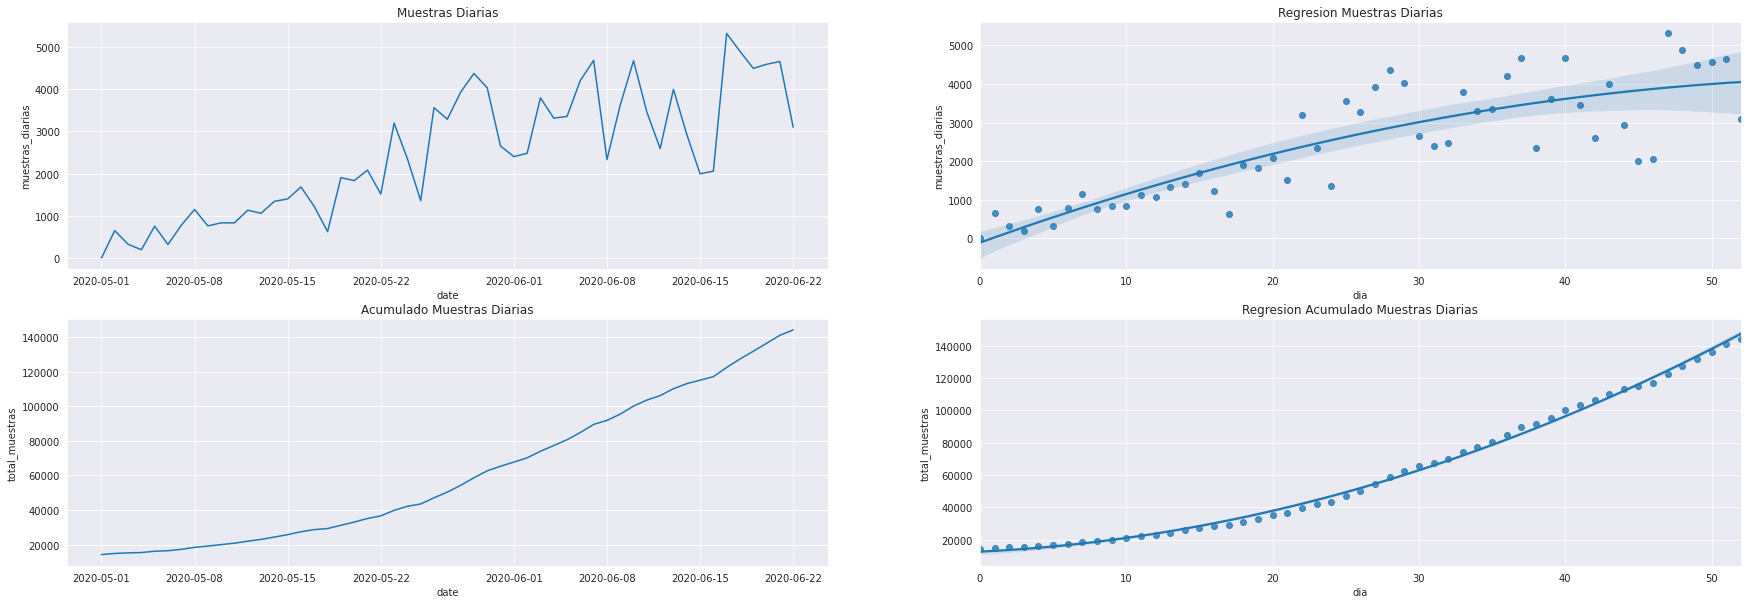

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
sns.lineplot(x="date", y="muestras_diarias", data=datos_arequipa, ax=ax1)
sns.regplot(x="dia", y="muestras_diarias", data=datos_arequipa, order=2, ax=ax2)
sns.lineplot(x="date", y="total_muestras", data=datos_arequipa, ax=ax3)
sns.regplot(x="dia", y="total_muestras", data=datos_arequipa, order=2, ax=ax4)

ax1.set(title='Muestras Diarias')
ax2.set(title='Regresion Muestras Diarias')
ax3.set(title='Acumulado Muestras Diarias')
ax4.set(title='Regresion Acumulado Muestras Diarias')

plt.show()

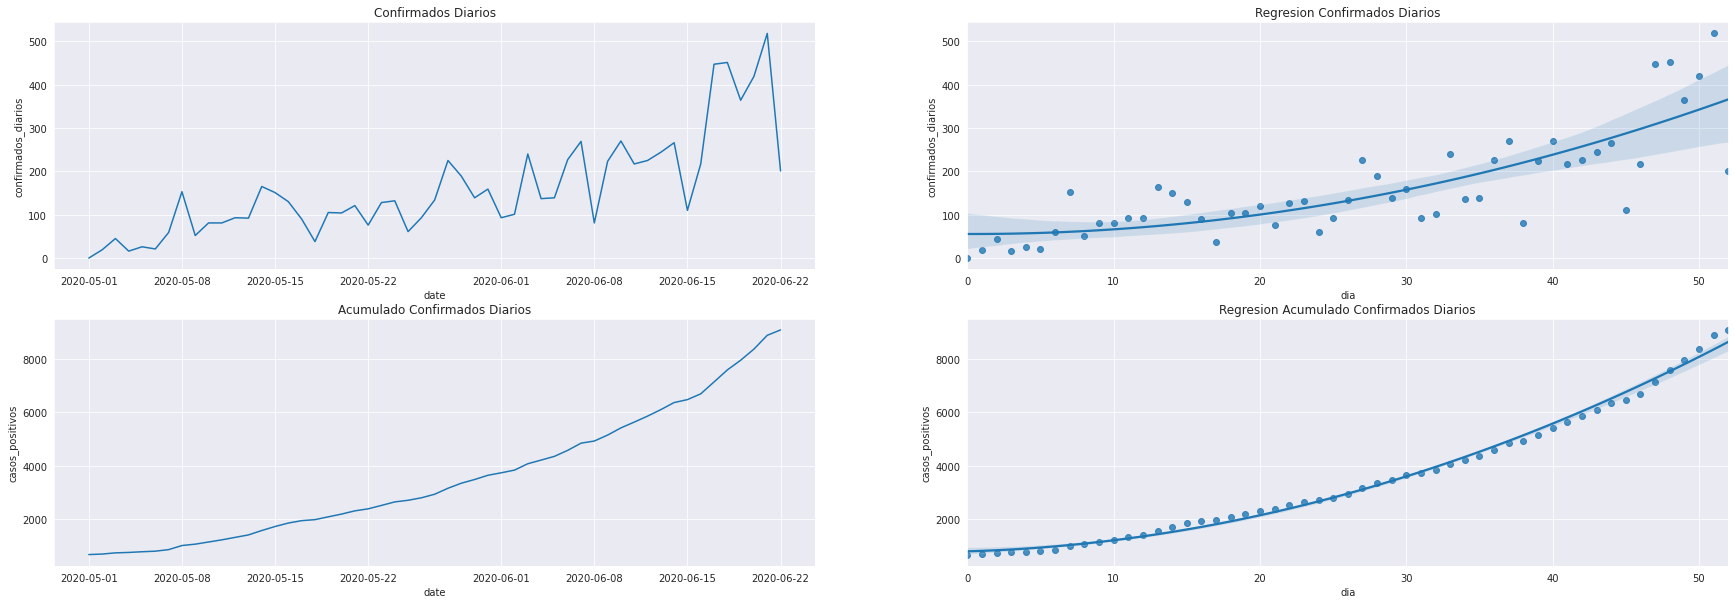

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
sns.lineplot(x="date", y="confirmados_diarios", data=datos_arequipa, ax=ax1)
sns.regplot(x="dia", y="confirmados_diarios", data=datos_arequipa, order=2, ax=ax2)
sns.lineplot(x="date", y="casos_positivos", data=datos_arequipa, ax=ax3)
sns.regplot(x="dia", y="casos_positivos", data=datos_arequipa, order=2, ax=ax4)

ax1.set(title='Confirmados Diarios')
ax2.set(title='Regresion Confirmados Diarios')
ax3.set(title='Acumulado Confirmados Diarios')
ax4.set(title='Regresion Acumulado Confirmados Diarios')

plt.show()

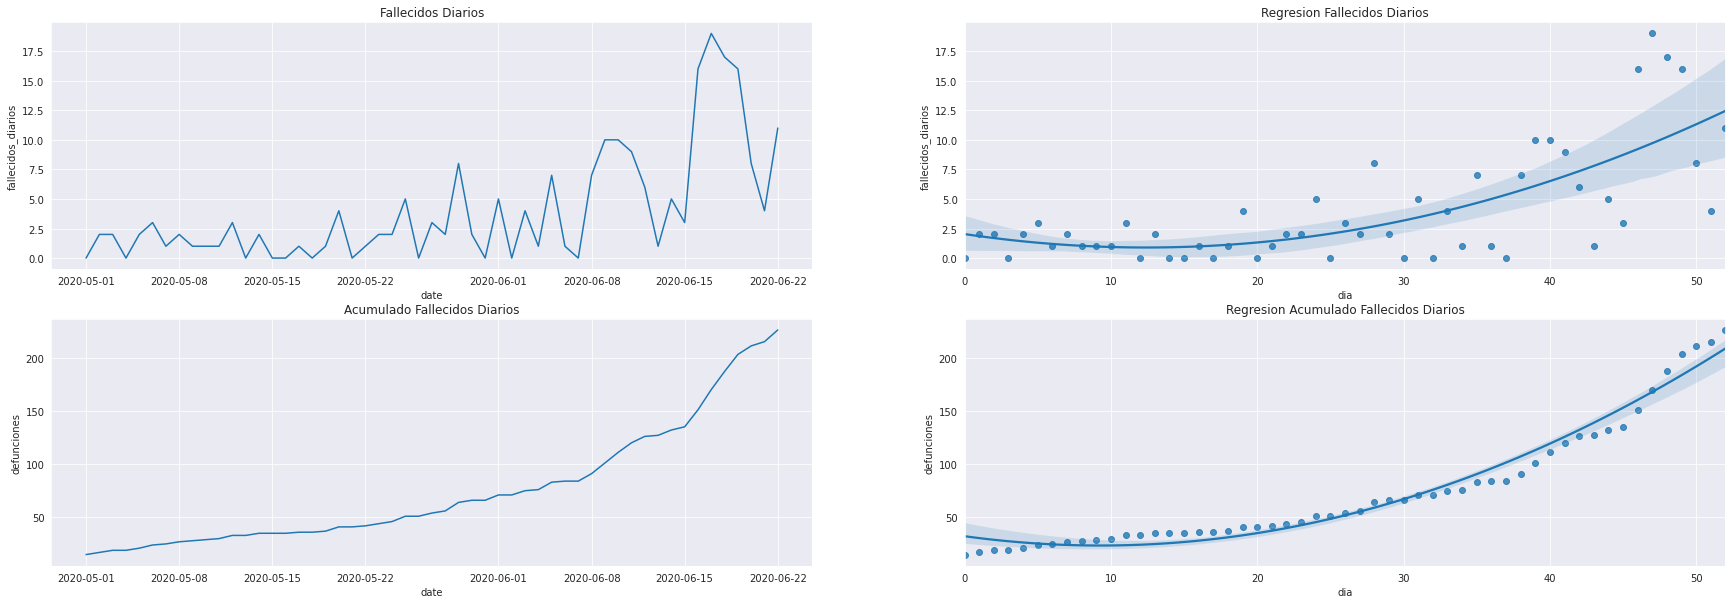

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
sns.lineplot(x="date", y="fallecidos_diarios", data=datos_arequipa, ax=ax1)
sns.regplot(x="dia", y="fallecidos_diarios", data=datos_arequipa, order=2, ax=ax2)
sns.lineplot(x="date", y="defunciones", data=datos_arequipa, ax=ax3)
sns.regplot(x="dia", y="defunciones", data=datos_arequipa, order=2, ax=ax4)

ax1.set(title='Fallecidos Diarios')
ax2.set(title='Regresion Fallecidos Diarios')
ax3.set(title='Acumulado Fallecidos Diarios')
ax4.set(title='Regresion Acumulado Fallecidos Diarios')

plt.show()

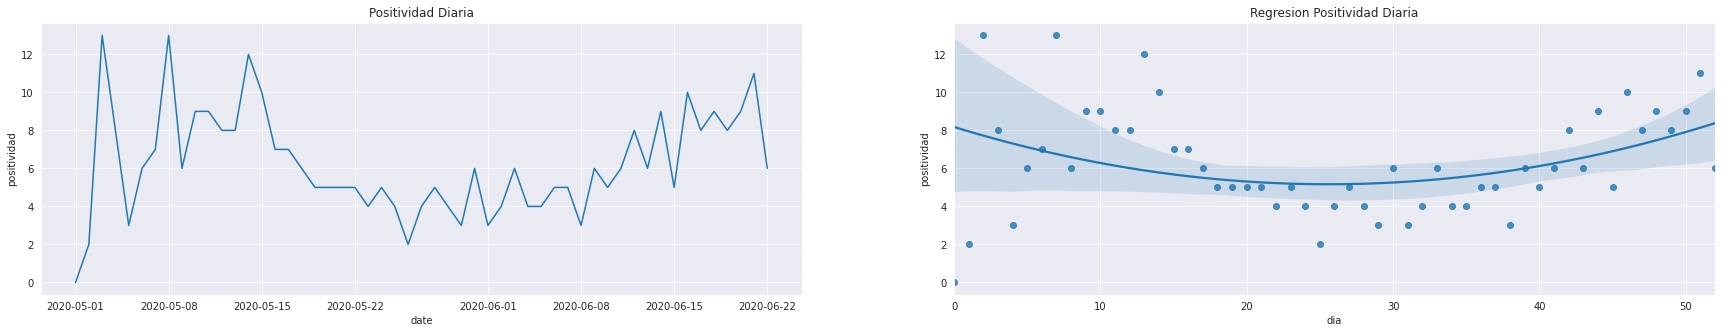

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 5))
sns.lineplot(x="date", y="positividad", data=datos_arequipa, ax=ax1)
sns.regplot(x="dia", y="positividad", data=datos_arequipa, order=2, ax=ax2)

ax1.set(title='Positividad Diaria')
ax2.set(title='Regresion Positividad Diaria')

plt.show()

In [ ]:
r_confirmados_arequipa = datos_arequipa.loc[:,['date', 'confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index(['state', 'date'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']

r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)

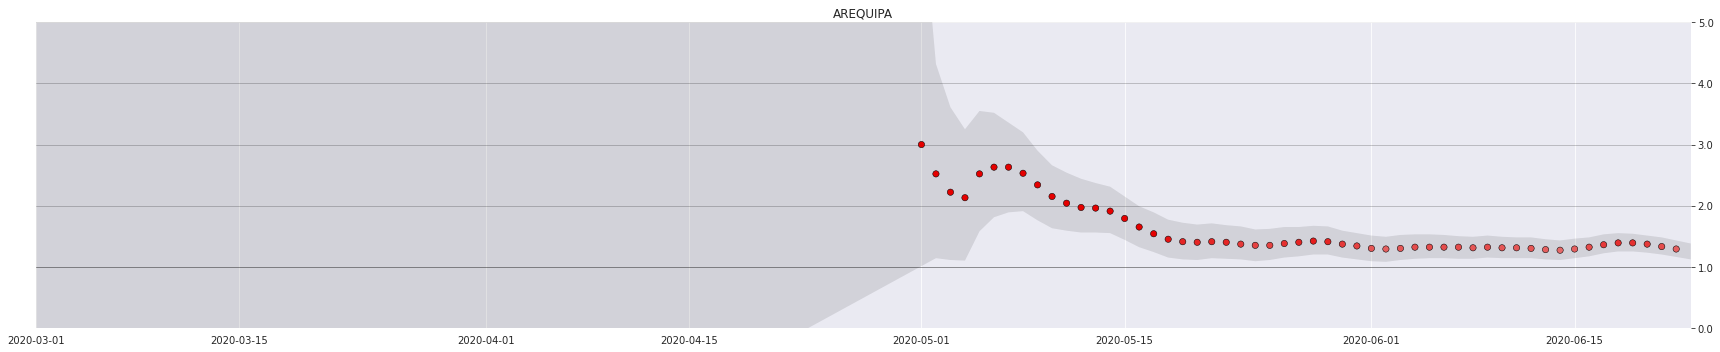

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(24, 5))
plot_rt(r_confirmados, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

In [ ]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['date', 'fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index(['state', 'date'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']

r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

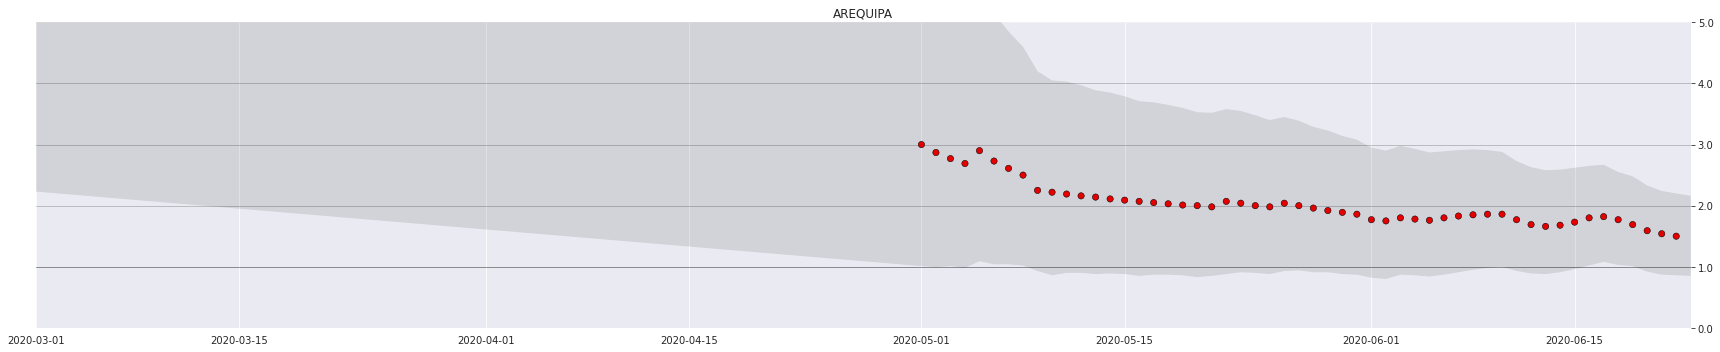

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(24, 5))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()